In [1]:
# TODO: save np.arrays as h5 files instead of .npy
# TODO: generator input deep learning
# TODO: post processing: reconstruct image from network output and create shape files
# TODO: contruct my own f1 score definition, perhaps take iou=0.5 per polygon. 

In [1]:
colab = False

In [2]:
if colab:
    from google.colab import drive
    drive.mount("/content/drive")

In [3]:
if colab:
    !pip install pandas
    !pip install matplotlib
    !pip install rasterio
    !pip install shapely
    !pip install descartes
    !pip install pyproj
    !pip install geopandas
    !pip install keras_unet
    !pip install h5py
    
    from IPython.display import display, HTML
    js = ('<script>function ConnectButton(){ '
            'console.log("Connect pushed"); '
            'document.querySelector("#connect").click()} '
            'setInterval(ConnectButton,3000);</script>')
    display(HTML(js))

In [4]:
from datetime import datetime
import sys
import geopandas as gpd
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from os.path import join
import descartes
from PIL import Image
import h5py

import fiona 
import pyproj
import time

import warnings
from importlib import reload

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import keras
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks as keras_cb 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# see: https://github.com/karolzak/keras-unet
from keras_unet.models import satellite_unet 
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.utils import get_augmented

from keras import backend as K

# # prevent Tensorflow memory leakage
# K.clear_session()

#warnings.simplefilter("ignore")
print(sys.executable)

if colab:
    sys.path.append("/content/drive/My Drive/app_UNOSAT")
    #sys.path.append("/content/drive/My Drive/app_UNOSAT/src")

from src import load_data as ld
from src import preprocessing as pp
from src import prepare_for_network as pfn
from src import utils as utl

Using TensorFlow backend.


/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/bin/python


In [5]:
#reload(pfn)

In [56]:
# local paths, set your own path here
if colab:
    #path_main = '/content/drive/My Drive/app_UNOSAT'
    path_main = '/content/drive/Computers/My Macbook Pro'
else:
    path_main = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge'

path_data_main = utl.make_dir(join(path_main, "data"))

#### put data in these dirs

# I choose:
# Training: Mosul, Najaf, Nasiryah
# Validation: Souleimaniye
# Test: Bagdad, Kirkouk, Samawah, Tikrit (no labels present)
path_data_local_train = join(path_data_main, 'Train_Dataset')
path_data_local_val = join(path_data_main, 'Validation_Dataset')
path_data_local_test = join(path_data_main, 'Evaluation_Dataset')

path_model =  utl.make_dir(join(path_data_main, 'model'))
path_checkpoints =  utl.make_dir(join(path_model, 'checkpoints'))

In [7]:
# other dirs are made automatically
dir_temp_data =  utl.make_dir(join(path_data_main, 'data_temp'))
dir_temp_train = utl.make_dir(join(dir_temp_data, 'train'))
dir_temp_val = utl.make_dir(join(dir_temp_data, 'val'))
dir_temp_dev = utl.make_dir(join(dir_temp_data, 'data_dev'))
dir_temp_eval = utl.make_dir(join(dir_temp_data, 'evaluation'))
dir_temp_plots = utl.make_dir(join(dir_temp_data, 'plots_preprocessing'))

In [8]:
# settings preprocessing
quantile_clip_max = 0.999
size_sub_sample = (512, 512)
dtype = 'i16'
inv_stride = 2

## Load and preprocess data

All files in 'Train_Dataset' are automatically selected for training (saved in sub dir 'whole'). All files in 'Validation_Dataset' are automatically selected for validation. All files in 'Evaluation_Dataset' are automatically selected for testing.<br>
Data (.tif files) and labels (.shp files) are both converted to .hdf5 files. First preprocessing is done for the .tif files (clip at quantile 'quantile_clip_max'). The label files become mask arrays, with 1=urban area and 0=non-urban area.

### develop (don't run for pipeline)

#### HDF5

In [9]:
def pad_zeros_xy_single_side(arr, size_sub_sample):
    shape_x, shape_y = arr.shape
    dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
    dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]

    arr_zeros_stack_x = np.zeros((dim_x_add, shape_y), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    print("arr.shape:", arr.shape)
    return arr


def pad_zeros_xy(arr, dim_x_add, dim_y_add, both_sides=False):
    """make array dimension a multiple of sub_sample_shape
    """
    arr_zeros_stack_x = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    if both_sides:
        arr = np.concatenate((arr_zeros_stack_x, arr), axis=0)
        
    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    
    if both_sides:
        arr =  np.concatenate((arr_zeros_stack_y, arr), axis=1)
    
    #print('new shape:', arr.shape)
    return arr




In [11]:
dtype = 'i8'
#dtype = 'i16'
sub_sample_shape = (512, 512)
dict_paths = ld.paths_in_dict(path_data_local_train)
file_hfd5 = join(dir_temp_dev,  'testrun_X.hdf5')

In [86]:
# preprocessing with hdf5
dtype = 'i8'
dict_paths = ld.paths_in_dict(path_data_local_train)
path_file_hfd5 = join(dir_temp_train,  'groups_test_X.hdf5')

with h5py.File(file_hfd5, 'w') as f:
    for area in dict_paths:
        print(area)
        i = 0
        #g = f.create_group(area)
        dir_save_plots = utl.make_dir(join(dir_temp_plots, area))        
        
        for season in ld.seasons_fixed_order:
            for pol in sorted(dict_paths[area]['tif'][season]):
                print(' ', season, pol)
                path_raster = dict_paths[area]['tif'][season][pol]
                np_arr_processed = pp.process_image(rio.open(path_raster).read()[0], 
                                                    quantile_clip_max,
                                                    clip_min=0, 
                                                    plotting=True, 
                                                    dir_save_plots=dir_save_plots,
                                                    area=area,  season=season, pol=pol)

                shape_x, shape_y = np_arr_processed.shape
                dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
                dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]
                
                #np_arr_processed = pad_zeros_xy(np_arr_processed, dim_x_add, dim_y_add)
                #np_arr_shape_new = np_arr_processed.shape + (1,)
                stacked_shape = (shape_x + dim_x_add, shape_y + dim_y_add)  + (8,)        
                
                if i == 0:
                    dset = f.create_dataset(area, 
                                            stacked_shape,
                                            dtype=dtype,
                                            chunks=True)
                    print(' shape init', dset.shape)
                    
                dset[:, :, i] = pad_zeros_xy(np_arr_processed, dim_x_add, dim_y_add)
                i += 1
                
        print("shape dataset:", dset.shape)

Mosul
  winter vh
new shape: (11264, 11264)
 shape init (11264, 11264, 8)
  winter vv
new shape: (11264, 11264)
  spring vh
new shape: (11264, 11264)
  spring vv
new shape: (11264, 11264)
  summer vh
new shape: (11264, 11264)
  summer vv
new shape: (11264, 11264)
  autumn vh
new shape: (11264, 11264)
  autumn vv
new shape: (11264, 11264)
shape dataset: (11264, 11264, 8)
Najaf
  winter vh
new shape: (11264, 11264)
 shape init (11264, 11264, 8)
  winter vv
new shape: (11264, 11264)
  spring vh
new shape: (11264, 11264)
  spring vv
new shape: (11264, 11264)
  summer vh
new shape: (11264, 11264)
  summer vv
new shape: (11264, 11264)
  autumn vh
new shape: (11264, 11264)
  autumn vv
new shape: (11264, 11264)
shape dataset: (11264, 11264, 8)
Nasiryah
  winter vh
new shape: (11264, 11264)
 shape init (11264, 11264, 8)
  winter vv
new shape: (11264, 11264)
  spring vh
new shape: (11264, 11264)
  spring vv
new shape: (11264, 11264)
  summer vh
new shape: (11264, 11264)
  summer vv
new shape: (1

In [73]:
with h5py.File(path_file_hfd5, 'r') as f:
    for k in f.keys():
        print(k)

Mosul
Najaf
Nasiryah


In [99]:
file_hfd5_labels = join(dir_temp_dev, 'testrun_Y.hdf5')
dict_paths = ld.paths_in_dict(path_data_local_train)


In [100]:
def shp2polygons(dict_paths):
    dict_polygons = dict()   
    for area in dict_paths:
        path_shape = dict_paths[area]['shp']
        dict_polygons[area] = gpd.read_file(path_shape)
    return dict_polygons
                
def preprocess_shape(dict_paths, file_hfd5_labels, sub_sample_shape):
    with h5py.File(file_hfd5_labels, 'w') as f:
        for area in dict_paths:
            print(area)

            dict_polygons = shp2polygons(dict_paths)

            # raster obj only required for shape and crs, this is season or pol independent
            path_raster = dict_paths[area]['tif']['spring']['vh']
            raster_obj = rio.open(path_raster)
            arr_shape = raster_obj.shape

            dim_x_add = sub_sample_shape[0] - arr_shape[0] % sub_sample_shape[0]
            dim_y_add = sub_sample_shape[1] - arr_shape[1] % sub_sample_shape[1]       
            arr_new_shape = (arr_shape[0] + dim_x_add,  arr_shape[1] + dim_y_add)

            dset = f.create_dataset(area, 
                                    arr_new_shape,
                                    dtype=dtype,
                                    chunks=True)

            dset[:] = pad_zeros_xy(pp.polygons_2_np_arr_mask(dict_polygons[area], 
                                                                 raster_obj),
                                   dim_x_add,
                                   dim_y_add
                                  )       

Mosul
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 4316046
Najaf
polygon mask shape: (10980, 10980)
sum polygon_mask_int: 3709703
Nasiryah
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 1228702


### Training data

In [9]:
t0 = time.time()
dict_paths_train = ld.paths_in_dict(path_data_local_train)

file_hfd5_train_X = join(dir_temp_train, 'MosNajNaS_20191220_X_{}.hdf5'.format(size_sub_sample[0]))
file_hfd5_train_Y = join(dir_temp_train, 'MosNajNaS_20191220_Y_{}.hdf5'.format(size_sub_sample[0]))

pp.preprocces_data(dict_paths_train, file_hfd5_train_X, quantile_clip_max, size_sub_sample, dtype, dir_temp_plots)
pp.preprocess_shape(dict_paths_train, file_hfd5_train_Y, sub_sample_shape)

print('takes {} mins'.format(round((time.time() - t0)/60)))

preprocessing...
Mosul
  winter vh
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
Najaf
  winter vh
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
Nasiryah
  winter vh
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 4316046
polygon mask shape: (10980, 10980)
sum polygon_mask_int: 3709703
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 1228702
stack and save arrays...
Mosul
Najaf
Nasiryah
save labels...
takes 5 mins


### validation data

In [10]:
t0 = time.time()
dict_paths_val = ld.paths_in_dict(path_data_local_val)

file_hfd5_val_X = join(dir_temp_val, 'MosNajNaS_20191220_X_{}.hdf5'.format(size_sub_sample[0]))
file_hfd5_val_Y = join(dir_temp_val, 'MosNajNaS_20191220_Y_{}.hdf5'.format(size_sub_sample[0]))

pp.preprocces_data(dict_paths_val, file_hfd5_val_X, quantile_clip_max, size_sub_sample, dtype, dir_temp_plots)
pp.preprocess_shape(dict_paths_val, file_hfd5_val_Y, sub_sample_shape)

print('takes {} mins'.format(round((time.time() - t0)/60)))

preprocessing...
Souleimaniye
  winter vh
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
polygon mask shape: (10979, 10980)
sum polygon_mask_int: 1861770
stack and save arrays...
Souleimaniye
save labels...
takes 2 mins


### Test data

In [ ]:
t0 = time.time()
dict_paths_test = ld.paths_in_dict(path_data_local_test)

file_hfd5_test_X = join(dir_temp_test, 'MosNajNaS_20191220_X_{}.hdf5'.format(size_sub_sample[0]))
file_hfd5_test_Y = join(dir_temp_test, 'MosNajNaS_20191220_Y_{}.hdf5'.format(size_sub_sample[0]))

pp.preprocces_data(dict_paths_test, file_hfd5_test_X, quantile_clip_max, size_sub_sample, dtype, dir_temp_plots)
pp.preprocess_shape(dict_paths_test, file_hfd5_test_Y, sub_sample_shape)

print('takes {} mins'.format(round((time.time() - t0)/60)))

## prepare data for network

Images and labels are in .npy / .h5 file shape now, but they need to be converted to suitable input for a network.
Therefore a full image is cut into many sub-samples of size 'size_sub_sample', e.g. (512, 512). This requires first zero padding (func zero_padding_1) in order to fit the image to an integer times size_sub_sample. <br>
Then we augment data by using a stride of size_sub_sample/inv_stride, i.e. we shift the image by for example half a sample size (inv_stride=2). Subsequently we cut into sub-images.  This results in inv_stride<sup>2</sup> times more data. In order to fit n sub-samples into a shifted image, new padding is required (func zero_padding_2). <br>
Output is saved in sub dir 'split'.

### develop (don't run for pipeline)

#### HDF5

In [13]:
# def get_all(name):
#     print(name)

# def get_shape(ds):
#     print(ds.shape)
    
# with h5py.File(path_hd5, 'r') as f:
#     for key in f.keys():
#         ds = f[key]
#         print(ds.shape)

In [14]:
def zero_padding_2(arr, dim_str, inv_stride, size_sub_sample):
    """ padding array to fit stride
    """
    #print('padding 2:')
    #print(' dim_str:', dim_str)
    if dim_str:
        if 'x' in dim_str:
            dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
            arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=0)
            arr = np.concatenate((arr_zeros_stack, arr), axis=0)
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)

    #print(" new size array:", arr.shape)
    return arr

In [15]:
def split_array_2D(array, nrows, ncols):
    """Split a matrix into sub-matrices of shape (nrows, ncols)"""
    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                                     .swapaxes(1, 2)
                                     .reshape(-1, nrows, ncols))
    arr_4D_resh1 = np.array(list_3D_arrs)
    return arr_4D_resh1.reshape(arr_4D_resh1.shape[1], arr_4D_resh1.shape[0], 
                                arr_4D_resh1.shape[2], arr_4D_resh1.shape[3])

def list_stride(mode):
    if mode == 0:
        return ['_']
    if mode == 1:
        return ['_', 'x', 'y', 'xy']

In [79]:
# test
test_arr = np.array([1,1])

with h5py.File('test.hdf5', 'w') as f:
    g = f.create_group('Base_Group')
    d = g.create_dataset('default', data=test_arr)

    metadata = {'Date': time.time()}

    f.attrs.update(metadata)

    for m in f.attrs.keys():
        print('{} => {}'.format(m, f.attrs[m]))

Date => 1576842805.787124


In [16]:
def prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img=8):
    t0 = time.time()
    with h5py.File(file_split_hfd5, 'w') as f2:
        with h5py.File(file_hfd5, 'r') as f1:

            idx_i = 0
            meta_data = dict()

            for area in sorted(f1.keys()):
                print(area)
                dset = f1[area]
                print(dset.shape)

                for dim_str in list_stride(stride_mode):
                    print("dim_str:", dim_str)
                    np_arr_shape = list(dset.shape)
                    if 'x' in dim_str:
                        np_arr_shape[0] = np_arr_shape[0] + size_sub_sample[0]
                    if 'y' in dim_str:
                        np_arr_shape[1] = np_arr_shape[1] + size_sub_sample[1]

                    idx_j = int(np_arr_shape[0] * np_arr_shape[1] / (size_sub_sample[0] * size_sub_sample[1])) + idx_i

                    if dataset_kind == 'labels':
                        np_arr_shape_split = (idx_j,) + size_sub_sample
                        maxshape = (None,) + size_sub_sample
                    elif dataset_kind == 'data':
                        np_arr_shape_split = (idx_j,) + size_sub_sample + (depth_img,)
                        maxshape = (None,) + size_sub_sample + (depth_img,)

                    if idx_i == 0:
                        dset2 = f2.create_dataset(name_dset, 
                                                    np_arr_shape_split,
                                                    dtype=dtype,
                                                    maxshape=maxshape,
                                                    chunks=True)

                    if dataset_kind == 'labels':
                        dset2.resize((idx_j,) + size_sub_sample)
                        dset2[idx_i:idx_j,:,:] = split_array_2D(zero_padding_2(dset[:], 
                                                                           dim_str,
                                                                           inv_stride, 
                                                                           size_sub_sample), 
                                                                size_sub_sample[0], 
                                                                size_sub_sample[1])
                    elif dataset_kind == 'data':
                        for k in range(depth_img):
                            dset2.resize((idx_j,) + size_sub_sample + (depth_img,))
                            dset2[idx_i:idx_j,:,:,k] = split_array_2D(zero_padding_2(dset[:,:,k], 
                                                                           dim_str,
                                                                           inv_stride, 
                                                                           size_sub_sample), 
                                                                        size_sub_sample[0], 
                                                                        size_sub_sample[1])
                    print("dset2.shape:", dset2.shape)
                    print('idx i,j:', idx_i, idx_j)
                    meta_data[area + ' ' + dim_str] = (idx_i, idx_j)
                    idx_i = idx_j

                f2.attrs.update(meta_data)

    print('takes {} mins'.format(round((time.time() - t0) / 60)))
    

In [17]:
file_hfd5 =  join(dir_temp_dev,  'testrun_X.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'testrun_X_split.hdf5')
depth_img = 8
stride_mode = 1
name_dset = 'all_train_data_X'
dataset_kind = 'data'


prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img)

Mosul
(11264, 11264, 8)
dim_str: _
dset2.shape: (484, 512, 512, 8)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512, 8)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512, 8)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512, 8)
idx i,j: 1496 2025
Najaf
(11264, 11264, 8)
dim_str: _
dset2.shape: (2509, 512, 512, 8)
idx i,j: 2025 2509
dim_str: x
dset2.shape: (3015, 512, 512, 8)
idx i,j: 2509 3015
dim_str: y
dset2.shape: (3521, 512, 512, 8)
idx i,j: 3015 3521
dim_str: xy
dset2.shape: (4050, 512, 512, 8)
idx i,j: 3521 4050
Nasiryah
(11264, 11264, 8)
dim_str: _
dset2.shape: (4534, 512, 512, 8)
idx i,j: 4050 4534
dim_str: x
dset2.shape: (5040, 512, 512, 8)
idx i,j: 4534 5040
dim_str: y
dset2.shape: (5546, 512, 512, 8)
idx i,j: 5040 5546
dim_str: xy
dset2.shape: (6075, 512, 512, 8)
idx i,j: 5546 6075
takes 72 mins


In [18]:
file_hfd5 =  join(dir_temp_dev,  'testrun_Y.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'testrun_Y_split.hdf5')
stride_mode = 1
name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind)

Mosul
(11264, 11264)
dim_str: _
dset2.shape: (484, 512, 512)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512)
idx i,j: 1496 2025
Najaf
(11264, 11264)
dim_str: _
dset2.shape: (2509, 512, 512)
idx i,j: 2025 2509
dim_str: x
dset2.shape: (3015, 512, 512)
idx i,j: 2509 3015
dim_str: y
dset2.shape: (3521, 512, 512)
idx i,j: 3015 3521
dim_str: xy
dset2.shape: (4050, 512, 512)
idx i,j: 3521 4050
Nasiryah
(11264, 11264)
dim_str: _
dset2.shape: (4534, 512, 512)
idx i,j: 4050 4534
dim_str: x
dset2.shape: (5040, 512, 512)
idx i,j: 4534 5040
dim_str: y
dset2.shape: (5546, 512, 512)
idx i,j: 5040 5546
dim_str: xy
dset2.shape: (6075, 512, 512)
idx i,j: 5546 6075
takes 3 mins


In [113]:
# t0 = time.time()

# file_hfd5_labels_split =  join(dir_temp_dev,  'testrun_Y_split.hdf5')

# name_dset = 'all_train_data_Y'

# with h5py.File(file_hfd5_labels_split, 'w') as f2:
#     with h5py.File(file_hfd5_labels, 'r') as f1:
#         idx_i = 0
#         meta_data = dict()
        
#         for area in f1.keys():
#             print(area)
#             dset = f1[area]
#             print(dset.shape)

#             for dim_str in ['_', 'x', 'y', 'xy']:
#                 print("dim_str:", dim_str)
#                 np_arr_shape = list(dset.shape)
#                 if 'x' in dim_str:
#                     np_arr_shape[0] = np_arr_shape[0] + size_sub_sample[0]
#                 if 'y' in dim_str:
#                     np_arr_shape[1] = np_arr_shape[1] + size_sub_sample[1]
                
#                 idx_j = int(np_arr_shape[0] * np_arr_shape[1] / (size_sub_sample[0] * size_sub_sample[1])) + idx_i
#                 np_arr_shape_split = (idx_j,) + size_sub_sample
                
#                 if idx_i == 0:
#                     dset2 = f2.create_dataset(name_dset, 
#                                                 np_arr_shape_split,
#                                                 dtype=dtype,
#                                                 chunks=True)
                
#                 print("dset2.shape:", dset2.shape)

#                 dset2[idx_i:idx_j,:,:] = split_array_2D(zero_padding_2(dset[:], 
#                                                                        dim_str,
#                                                                        inv_stride, 
#                                                                        size_sub_sample), 
#                                                         size_sub_sample[0], 
#                                                         size_sub_sample[1])
                
                
#                 print('idx i,j:', idx_i, idx_j)
#                 meta_data[area + ' ' + dim_str] = (idx_i, idx_j)
#                 idx_i = idx_j

#             f2.attrs.update(meta_data)
#             print("shape dataset:", dset2.shape)

# print("total time:", time.time() - t0)

In [72]:
#TODO: in a different separate step, concatenate datasets of areas
# see: https://stackoverflow.com/questions/43929420/how-to-concatenate-two-numpy-arrays-in-hdf5-format

# same for labels

Mosul
Najaf
Nasiryah


#### numpy

In [37]:
dir_label_dev = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/data_temp/train/labels'
area_file_label_dev = 'Mosul_label.npy'
arr_label_dev = np.load(join(dir_label_dev, 'whole', area_file_label_dev))

In [1]:
print(arr.shape)
dim_x = arr.shape[1]
dim_x_add = size_sub_sample[0] - dim_x % size_sub_sample[0]
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)

NameError: name 'arr' is not defined

In [2]:
dim_y = arr.shape[2]
dim_y_add = size_sub_sample[1] - dim_y % size_sub_sample[1]
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
print("new size padding 1:", arr.shape)

NameError: name 'arr' is not defined

In [3]:
print('x1:', arr.shape)
dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]),  dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=1)
arr = np.concatenate((arr_zeros_stack, arr), axis=1)
print('x2:', arr.shape)

dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add),  dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
arr = np.concatenate((arr_zeros_stack, arr), axis=2)

sys.getsizeof(arr) / 10**9, arr.shape

NameError: name 'arr' is not defined

In [41]:
def zero_padding_1(arr, sub_sample_shape):
    """make array dimension a multiple of sub_sample_shape
    """
    print(arr.shape)
    dim_x = arr.shape[1]
    dim_x_add = sub_sample_shape[0] - dim_x % sub_sample_shape[0]
    arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=1)

    dim_y = arr.shape[2]
    dim_y_add = sub_sample_shape[1] - dim_y % sub_sample_shape[1]
    arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=2)
    print("new size padding 1:", arr.shape)

    return arr


    dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
    dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]
    
def pad_zeros_xy(arr, dim_x_add, dim_y_add, both_sides=False):
    arr_zeros_stack_x = np.zeros((dim_x_add, shape_y), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    if both_sides:
        arr = np.concatenate((arr_zeros_stack_x, arr), axis=0)
        
    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    
    if both_sides:
        arr =  np.concatenate((arr_zeros_stack_y, arr), axis=1)
        
    return arr


def zero_padding_2(arr, dim_str, inv_stride, size_sub_sample):
    """ padding array to fit stride
    """
    print('padding 2:')
    print(' dim_str:', dim_str)
    if dim_str:
        if 'x' in dim_str:
            print('x1:', arr.shape)
            dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)
            print('x2:', arr.shape)
        
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=2)
            arr = np.concatenate((arr_zeros_stack, arr), axis=2)

    print(" new size array:", arr.shape)
    return arr

def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                                     .swapaxes(1, 2)
                                     .reshape(-1, nrows, ncols))
    arr_4D_resh1 = np.array(list_3D_arrs)
    return arr_4D_resh1.reshape(arr_4D_resh1.shape[1], arr_4D_resh1.shape[0], 
                                arr_4D_resh1.shape[2], arr_4D_resh1.shape[3])

def save_array_in_new_sub_dir(arr, main_dir, name_new_dir, filename, dim_str):
    print('save_array_in_new_sub_dir')
    name_new_dir = 'split'
    dir_data_split = join(main_dir, name_new_dir) 
    ld.make_dir(dir_data_split)
    path_file_split = join(dir_data_split, os.path.splitext(filename)[0] + '_' + name_new_dir + '_' + dim_str)
    np.save(path_file_split, arr)
    del arr
    gc.collect()
    
    

            

In [42]:
def split_array_2D(array, nrows, ncols):
    """Split a matrix into sub-matrices and ."""
    r, h = array.shape
    arr_3D = array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)
    return [arr for arr in arr_3D]


def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                             .swapaxes(1, 2)
                             .reshape(-1, nrows, ncols))
    
        arr_4D = np.array(list_3D_arrs)
        
    arr_4D = arr_4D.reshape(arr_4D.shape[1], arr_4D.shape[0], arr_4D.shape[2], arr_4D.shape[3])
    return [arr for arr in arr_4D]

def save_samples(list_arrs, main_dir, name_new_dir, filename, dim_str):
    print('  save samples')
    dir_data_split = join(main_dir, name_new_dir)
    ld.make_dir(dir_data_split)

    str_filename =  os.path.splitext(filename)[0] + '_' + name_new_dir + '_' + dim_str + '_{}' 
    for i, arr in enumerate(list_arrs):
        path_file_split = join(dir_data_split, str_filename.format(i))
        np.save(path_file_split, arr)
    del arr
    gc.collect()

    
def zero_padding_1_labels(arr, sub_sample_shape):
    """make array dimension a multiple of sub_sample_shape
    """
    print('  padding 1')
    dim_x = arr.shape[0]
    dim_x_add = sub_sample_shape[0] - dim_x % sub_sample_shape[0]
    arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=0)

    dim_y = arr.shape[1]
    dim_y_add = sub_sample_shape[1] - dim_y % sub_sample_shape[1]
    arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=1)
    print("   new size padding 1:", arr.shape)

    return arr

def zero_padding_2_labels(arr, dim_str, inv_stride, size_sub_sample):
    """ padding array to fit stride
    """
    print('  padding 2:')
    print('    dim_str:', dim_str)
    if dim_str:
        if 'x' in dim_str:
            dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
            arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=0)
            arr = np.concatenate((arr_zeros_stack, arr), axis=0)
        
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)

    print("   new size array:", arr.shape)
    return arr

In [39]:
# zero padding 1
dim_x = arr.shape[1]
dim_x_add = size_sub_sample[0] - dim_x % size_sub_sample[0]
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=1)

dim_y = arr.shape[2]
dim_y_add = size_sub_sample[1] - dim_y % size_sub_sample[1]
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
print("new size padding 1:", arr.shape)

new size padding 1: (8, 11264, 11264)


In [43]:
# rest of pipeline
for dim_str in ['', 'x', 'y', 'xy']:
    #zero padding 2
    arr_area_2 = zero_padding_2(arr, dim_str, inv_stride, size_sub_sample)
    print('pad 2',sys.getsizeof(arr_area_2) / 10**9, arr_area_2.shape)

    #split
    list_arrs = split_array_3D(arr_area_2, size_sub_sample[0], size_sub_sample[1])
    print('len list:', len(list_arrs))
    print('shape arr:', list_arrs[0].shape)
    del arr_area_2
    gc.collect()
    
    save_samples(list_arrs, dir_data_dev, 'split', area_file_dev, dim_str)
    del list_arrs
    gc.collect()
    
del arr
gc.collect()



padding 2:
 dim_str: 
 new size array: (8, 11264, 11264)
pad 2 4.0600864 (8, 11264, 11264)
len list: 484
shape arr: (8, 512, 512)
  save samples
padding 2:
 dim_str: x
x1: (8, 11264, 11264)
x2: (8, 11776, 11264)
 new size array: (8, 11776, 11264)
pad 2 4.244635776 (8, 11776, 11264)


KeyboardInterrupt: 

In [29]:
arr_label_dev = zero_padding_1_labels(arr_label_dev, size_sub_sample)


for dim_str in ['', 'x', 'y', 'xy']:
    arr_area_2 = zero_padding_2_labels(arr_label_dev, dim_str, inv_stride, size_sub_sample)
    list_arrs = split_array_2D(arr_area_2, size_sub_sample[0], size_sub_sample[1])
    del arr_area_2
    gc.collect()
    print('len list:', len(list_arrs))
    save_samples(list_arrs, dir_label_dev, 'split', area_file_label_dev, dim_str)
    del list_arrs
    gc.collect()
del arr_area
gc.collect()

  padding 1
   new size padding 1: (13312, 13312)
  padding 2:
    dim_str: 
   new size array: (13312, 13312)
len list: 676
  save samples
  padding 2:
    dim_str: x
   new size array: (13824, 13312)
len list: 702
  save samples
  padding 2:
    dim_str: y
   new size array: (13312, 13824)
len list: 702
  save samples
  padding 2:
    dim_str: xy
   new size array: (13824, 13824)
len list: 729
  save samples


NameError: name 'arr_area' is not defined

### pipeline

#### training

In [11]:
file_hfd5 =  join(dir_temp_dev,  'testrun_X.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'testrun_X_split.hdf5')
depth_img = 8
stride_mode = 1
name_dset = 'all_train_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img)

Mosul.npy
  padding 1
   new size padding 1: (8, 11264, 11264)
 augmentation
  padding 2:
   dim_str: 
   new size array: (8, 11264, 11264)
len list: 484
  save samples
  padding 2:
   dim_str: x
   new size array: (8, 11776, 11264)
len list: 506
  save samples
  padding 2:
   dim_str: y
   new size array: (8, 11264, 11776)
len list: 506
  save samples
  padding 2:
   dim_str: xy
   new size array: (8, 11776, 11776)
len list: 529
  save samples
Najaf.npy
  padding 1
   new size padding 1: (8, 11264, 11264)
 augmentation
  padding 2:
   dim_str: 
   new size array: (8, 11264, 11264)
len list: 484
  save samples
  padding 2:
   dim_str: x
   new size array: (8, 11776, 11264)
len list: 506
  save samples
  padding 2:
   dim_str: y
   new size array: (8, 11264, 11776)
len list: 506
  save samples
  padding 2:
   dim_str: xy
   new size array: (8, 11776, 11776)
len list: 529
  save samples
Nasiryah.npy
  padding 1
   new size padding 1: (8, 11264, 11264)
 augmentation
  padding 2:
   dim_st

In [ ]:
file_hfd5 =  join(dir_temp_dev,  'testrun_Y.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'testrun_Y_split.hdf5')
stride_mode = 1
name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind)

#### validation

In [ ]:
#file_hfd5 =  join(dir_temp_dev,  'testrun_X.hdf5')
#file_split_hfd5 = join(dir_temp_dev,  'testrun_X_split.hdf5')
depth_img = 8
stride_mode = 1
name_dset = 'all_train_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_val_hfd5, file_val_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img)

In [ ]:
#file_hfd5 =  join(dir_temp_dev,  'testrun_Y.hdf5')
#file_split_hfd5 = join(dir_temp_dev,  'testrun_Y_split.hdf5')
stride_mode = 1
#name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_val_fd5, file_val_split_hfd5, stride_mode, name_dset, dataset_kind)

#### Test

In [ ]:
#file_hfd5 =  join(dir_temp_dev,  'testrun_X.hdf5')
#file_split_hfd5 = join(dir_temp_dev,  'testrun_X_split.hdf5')
depth_img = 8
stride_mode = 1
#name_dset = 'all_train_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_test_hfd5, file_test_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img)

In [ ]:
# no labels

## Deep learning

### develop (don't run for pipeline)

#### HDF5

In [ ]:
class My_Custom_Generator(Sequence):
    def __init__(self, file_hdf5_X, file_hdf5_Y, batch_size):
        self.file_hdf5_X = file_hdf5_X
        self.file_hdf5_Y = file_hdf5_Y
        self.batch_size = batch_size
     
    def __len__(self) :
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            len_dataset_Y = dataset_Y.shape[0]
        
        return (np.ceil(len_dataset_Y) / float(self.batch_size)).astype(np.int)
    
    def __getitem__(self, idx):
        with h5py.File(self.file_hdf5_X, 'r') as f1_X:
            dataset_X  = f1_X['all_train_data_X']
            batch_x = dataset_X[idx * self.batch_size : (idx+1) * self.batch_size, :, :, :]
        
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            batch_y = dataset_Y[idx * self.batch_size : (idx+1) * self.batch_size, :, :]

        return (batch_x, batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1))

In [11]:
file_hdf5_X = join(dir_temp_dev,  'testrun_X_split.hdf5')
file_hdf5_Y = join(dir_temp_dev,  'testrun_Y_split.hdf5')

In [12]:
my_training_batch_gen = My_Custom_Generator(file_hdf5_X, file_hdf5_Y, BS)

In [13]:
for i, arr in enumerate(my_training_batch_gen):
    print(arr[0].shape, arr[1].shape)
    if i>3:
        break

(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)


In [26]:
my_training_batch_gen.__len__(), len(my_training_batch_gen)

(3037, 3037)

In [15]:
with h5py.File(file_hdf5_X, 'r') as f1_Y:
    dataset_Y  = f1_Y['all_train_data_X']
    print(dataset_Y.shape)
    

(6075, 512, 512, 8)


In [ ]:
model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  # metrics=["accuracy"],
                  metrics=[iou, iou_thresholded])

In [ ]:
H = model.fit(dataset_X, dataset_Y,  
                 batch_size=BS, 
                epochs=EPOCHS, 
                verbose=1)

### load data dev

In [12]:
file_hdf5_X = join(dir_temp_dev,  'testrun_X_split.hdf5')
file_hdf5_Y = join(dir_temp_dev,  'testrun_Y_split.hdf5')

In [13]:
with h5py.File(file_hdf5_Y, 'r') as f1_Y:
    dsety  = f1_Y['all_train_data_Y']
    dataset_Y = dsety[:100]
    
dataset_Y = dataset_Y.reshape(dataset_Y.shape[0], dataset_Y.shape[1], dataset_Y.shape[2], 1)#.copy()

with h5py.File(file_hdf5_X, 'r') as f1_X:
    dsetx = f1_X['all_train_data_X']
    dataset_X = dsetx[:100]

In [14]:
dataset_Y.shape, dataset_X.shape

((100, 512, 512, 1), (100, 512, 512, 8))

In [15]:
dataset_X_1 = dataset_X[:,:,:,0:1]#.copy()

In [14]:
np.sum(dataset_X_1), np.sum(dataset_Y)

(11473, 81156)

In [15]:
dataset_Y.shape, dataset_X_1.shape

((32, 512, 512, 1), (32, 512, 512, 1))

In [16]:
sys.getsizeof(dataset_X_1) / 10**9, sys.getsizeof(dataset_Y) / 10**9

(0.067109008, 0.067109008)

In [17]:
BS

8

In [16]:
train_datagen_aug = get_augmented(
        dataset_X,
        dataset_Y.reshape(dataset_Y.shape[0], dataset_Y.shape[1], dataset_Y.shape[2], 1),
        X_val=None,
        Y_val=None,
        batch_size=BS,
        seed=0,
        data_gen_args=dict(
            rotation_range=90,
            height_shift_range=0,
            shear_range=0,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant'
        )
    )

/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (100, 512, 512, 8) (8 channels).
  ' channels).')
/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (100, 512, 512, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


#### numpy

In [ ]:
dir_train_X_split = join(dir_temp_train_X, 'split')
dir_train_Y_split = join(dir_temp_train_Y, 'split')

dir_val_X_split = join(dir_temp_val_X, 'split')
dir_val_Y_split = join(dir_temp_val_Y, 'split')

dir_test_X_split = join(dir_temp_test_X, 'split')

In [17]:
class My_Custom_Generator(Sequence):
    def __init__(self, dir_X, dir_Y, batch_size):
        self.list_files_X = [join(dir_X, file_name) for file_name in os.listdir(dir_X)]
        self.list_files_Y = [join(dir_Y, file_name) for file_name in os.listdir(dir_Y)]
        self.batch_size = batch_size
     
    def __len__(self) :
        return (np.ceil(len(self.list_files_X) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        batch_x_in = self.list_files_X[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_in = self.list_files_Y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        b_x = np.array([np.load(file_name) for file_name in batch_x_in if os.path.splitext(file_name)[1] == '.npy'])
        b_y = np.array([np.load(file_name) for file_name in batch_y_in if os.path.splitext(file_name)[1] == '.npy'])
        
        return (b_x.reshape(b_x.shape[0], b_x.shape[2], b_x.shape[3], b_x.shape[1]), 
                b_y.reshape(b_y.shape[0], b_y.shape[1], b_y.shape[2], 1))


In [18]:
my_training_batch_gen = My_Custom_Generator(dir_train_X_split, dir_train_Y_split, BS)
my_validation_batch_gen = My_Custom_Generator(dir_val_X_split, dir_val_Y_split, BS)

In [104]:
my_training_batch_gen.__len__() * 32

480

In [24]:
for i, arr in enumerate(my_training_batch_gen):
    print(arr[0].shape, arr[1].shape)
    if i>10:
        break

(31, 512, 512, 8) (31, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)
(32, 512, 512, 8) (32, 512, 512, 1)


In [32]:
# callbacks
filepath =join(path_model, "weights-improvement-{epoch:02d}-{iou:.2f}.hdf5")

cb_chk = keras_cb.ModelCheckpoint(filepath, monitor='iou', verbose=1, save_best_only=True, mode='max')
#cb_proglog = keras_cb.ProgbarLogger()
cb_es = keras_cb.EarlyStopping(patience=5)
#cb_tb = keras_cb.tensorboard_v1.TensorBoard(log_dir=join(path_model, 'logs'), histogram_freq=1, batch_size=BS, 
                                            #write_graph=True, write_grads=True, write_images=True, update_freq='epoch')
callbacks_list = [cb_chk, cb_es]

In [26]:
model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  # metrics=["accuracy"],
                  metrics=[iou, iou_thresholded])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
len(my_training_batch_gen.list_files_X) // BS

In [ ]:
H = model.fit_generator(generator=my_training_batch_gen,
                        steps_per_epoch=len(my_training_batch_gen.list_files_X) // BS,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        verbose=2,
#                         validation_data = my_validation_batch_gen,
#                         validation_steps = len(my_validation_batch_gen.list_files_X) // BS
                        )



Epoch 1/1


In [ ]:
model_json = model.to_json()
path_json_file = join(path_model, "model_{}.json".format(utl.datetime_now), "w") 
with open(path_json_file as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(join(path_model, "model_epochs_{}.h5".format(utl.datetime_now)))

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["iou"], label="train_iou")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/iou")
plt.legend(loc="lower left")
plt.savefig(join(path_model, "plot")

In [ ]:
# train_datagen = get_augmented(
#         trainX,
#         trainY,
#         X_val=None,
#         Y_val=None,
#         batch_size=BS,
#         seed=0,
#         data_gen_args=dict(
#             rotation_range=90,
#             height_shift_range=0,
#             shear_range=0,
#             horizontal_flip=True,
#             vertical_flip=True,
#             fill_mode='constant'
#         )
#     )

### pipeline

In [57]:
# params

BS = 2
EPOCHS = 2
size_sub_sample = (512, 512)

inv_stride = 2
INIT_LR = 1e-3
depth_img = 8

IMAGE_DIMS = size_sub_sample + (depth_img,)
model_init = satellite_unet(IMAGE_DIMS, num_layers=4)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

print(IMAGE_DIMS)

(512, 512, 8)


In [58]:
class My_Custom_Generator(Sequence):
    def __init__(self, file_hdf5_X, file_hdf5_Y, batch_size):
        self.file_hdf5_X = file_hdf5_X
        self.file_hdf5_Y = file_hdf5_Y
        self.batch_size = batch_size
     
    def __len__(self) :
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            len_dataset_Y = dataset_Y.shape[0]
        
        return (np.ceil(len_dataset_Y) / float(self.batch_size)).astype(np.int)
    
    def __getitem__(self, idx):
        with h5py.File(self.file_hdf5_X, 'r') as f1_X:
            dataset_X  = f1_X['all_train_data_X']
            batch_x = dataset_X[idx * self.batch_size : (idx+1) * self.batch_size, :, :, :]
        
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            batch_y = dataset_Y[idx * self.batch_size : (idx+1) * self.batch_size, :, :]

        return (batch_x, batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1))

In [59]:
file_hdf5_X = join(dir_temp_dev,  'testrun_X_split.hdf5')
file_hdf5_Y = join(dir_temp_dev,  'testrun_Y_split.hdf5')

In [60]:
my_training_batch_gen = My_Custom_Generator(file_hdf5_X, file_hdf5_Y, BS)

In [61]:
for i, arr in enumerate(my_training_batch_gen):
    print(arr[0].shape, arr[1].shape)
    if i>1:
        break
        
print(my_training_batch_gen.__len__(), len(my_training_batch_gen))

(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
3037 3037


In [62]:
batches_per_epoch_test = 10

In [63]:
def get_init_epoch(filepath_chk):
    return int(filepath_chk.split('-')[2])

In [65]:
#checkpoints
filepath_chk = None
for i, file in enumerate(os.listdir(path_checkpoints)): 
    if i == len(os.listdir(path_checkpoints)) - 1:
        if file != '.DS_Store':
            filepath_chk = join(path_checkpoints, file)
            print('checkpoint use: {}'.format(filepath_chk))
            
            
if filepath_chk is not None:
    
    # Load model:
    print('loading model')
    model = load_model(filepath_chk)
    
    # Finding the epoch index from which we are resuming
    print('find epoch')
    initial_epoch = get_init_epoch(filepath_chk)
    
#     # Calculating the correct value of count
#     count = initial_epoch*batches_per_epoch_test
#     # Update the value of count in callback instance
#     callbacks_list[1].count = count

 
    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-2)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))
    
    
else:
#   model = model_init
    filepath_chk = join(path_checkpoints, "weights-improvement-{epoch:02d}-{iou:.3f}.hdf5")
    initial_epoch = 0
    model = model_init
    model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  # metrics=["accuracy"],
                  metrics=[iou, iou_thresholded])
    
print('initial_epoch:', initial_epoch)

initial_epoch: 0


In [66]:
# callbacks
cb_chk = keras_cb.ModelCheckpoint(filepath_chk, monitor='iou', verbose=1, save_best_only=True, 
                                  mode='max', save_weights_only=False)
#cb_proglog = keras_cb.ProgbarLogger()
cb_es = keras_cb.EarlyStopping(patience=5)
cb_tb = keras_cb.TensorBoard(log_dir=join(path_model, 'tensorboard_logs'), histogram_freq=1, batch_size=BS, 
                                            write_graph=True, write_grads=True, write_images=True, 
                                            update_freq='epoch')
callbacks_list = [cb_chk, cb_es]# cb_tb]

In [ ]:
H = model.fit_generator(generator=my_training_batch_gen,
                        steps_per_epoch=batches_per_epoch_test,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        verbose=1,
                        #use_multiprocessing=True,
                        #workers=6, 
                        #max_queue_size=32,
                        initial_epoch=initial_epoch
                        )

Epoch 1/2


In [50]:
model_json = model.to_json()
path_json_file = join(path_model, "model_{}.json".format(utl.datetime_now()))
with open(path_json_file, 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(join(path_model, "model_epochs_{}.h5".format(utl.datetime_now)))

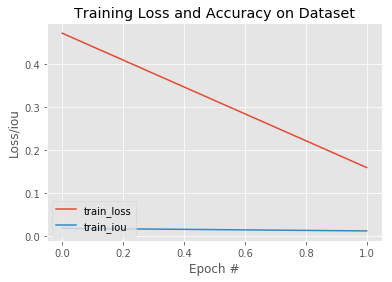

In [51]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["iou"], label="train_iou")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/iou")
plt.legend(loc="lower left")
file_plot_train_info = join(path_model, 'info_train_{}.png'.format(utl.datetime_now()))
plt.savefig(file_plot_train_info)
